In [1]:
# !pip install librosa matplotlib numpy 
# !pip install scikit-learn imbalanced-learn -q
# !pip install xgboost -q
# !pip install seaborn -q
# !pip install tensorflow -q

In [26]:
# Imports padrão
import os
import glob
import pickle
from collections import Counter
import zipfile
import shutil
import joblib

# Manipulação e visualização
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Processamento de áudio
import librosa
import librosa.display

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
# Deep Learning (Keras)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


# Importação dos Dados

In [28]:
ZIP_FILE_PATH = 'datasets/PlantSounds.zip'
BASE_PATH = os.path.join(
    'datasets',
    'plant_sounds_dataset'
)

# Garante que o diretório exista
os.makedirs(BASE_PATH, exist_ok=True)

try:
    # Extrai o ZIP
    with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
        zip_ref.extractall(BASE_PATH)

    print(f"Extração concluída com sucesso em: {BASE_PATH}")

except FileNotFoundError:
    print(f"ERRO: Arquivo ZIP não encontrado em: {ZIP_FILE_PATH}")
except Exception as e:
    print(f"Ocorreu um erro durante a extração: {e}")


Extração concluída com sucesso em: datasets\plant_sounds_dataset


 # Entendimento dos Dados

In [4]:
folders = ['Tomato Dry', 'Tomato Cut', 'Tobacco Dry', 'Tobacco Cut', 'Empty Pot']

for folder in folders:
    folder_path = os.path.join(BASE_PATH, folder)
    files = glob.glob(os.path.join(folder_path, '*'))
    print(f"Pasta: {folder} | Total de arquivos: {len(files)}")
    if files:
        print(f"Arquivo exemplo: {files[0]}")
    print("-" * 30)

Pasta: Tomato Dry | Total de arquivos: 1622
Arquivo exemplo: datasets\plant_sounds_dataset\Tomato Dry\id_101_sound_1.wav
------------------------------
Pasta: Tomato Cut | Total de arquivos: 660
Arquivo exemplo: datasets\plant_sounds_dataset\Tomato Cut\id_121_sound_1.wav
------------------------------
Pasta: Tobacco Dry | Total de arquivos: 275
Arquivo exemplo: datasets\plant_sounds_dataset\Tobacco Dry\id_10_sound_1.wav
------------------------------
Pasta: Tobacco Cut | Total de arquivos: 506
Arquivo exemplo: datasets\plant_sounds_dataset\Tobacco Cut\id_126_sound_1.wav
------------------------------
Pasta: Empty Pot | Total de arquivos: 1036
Arquivo exemplo: datasets\plant_sounds_dataset\Empty Pot\id_0_sound_1.wav
------------------------------


In [5]:
n_samples = 10  # Número de arquivos por categoria
stats_data = []

for folder in folders:
    folder_path = os.path.join(BASE_PATH, folder)
    files = glob.glob(os.path.join(folder_path, '*.wav'))[:n_samples]

    for file_path in files:
        try:
            y, sr = librosa.load(file_path, sr=None)

            # Calcular estatísticas
            stats_data.append({
                'Categoria': folder,
                'Arquivo': os.path.basename(file_path),
                'Taxa_Amostragem_kHz': sr / 1000,
                'Duracao_ms': (len(y) / sr) * 1000,
                'Num_Amostras': len(y),
                'Amplitude_Max': np.max(np.abs(y)),
                'Amplitude_Media': np.mean(np.abs(y)),
                'Amplitude_Std': np.std(y),
                'Energia_RMS': np.sqrt(np.mean(y**2)),
                'Zero_Crossing_Rate': np.mean(librosa.feature.zero_crossing_rate(y)[0])
            })
        except Exception as e:
            print(f"Erro ao processar {os.path.basename(file_path)}: {e}")

df_stats = pd.DataFrame(stats_data)

summary = df_stats.groupby('Categoria').agg({
    'Duracao_ms': ['mean', 'std'],
    'Amplitude_Max': ['mean', 'std'],
    'Amplitude_Media': ['mean', 'std'],
    'Energia_RMS': ['mean', 'std'],
    'Zero_Crossing_Rate': ['mean', 'std']
}).round(6)

print(summary)


            Duracao_ms      Amplitude_Max           Amplitude_Media            \
                  mean  std          mean       std            mean       std   
Categoria                                                                       
Empty Pot        2.002  0.0      0.332538  0.311738        0.012746  0.006592   
Tobacco Cut      2.002  0.0      0.369366  0.140667        0.014412  0.006472   
Tobacco Dry      2.002  0.0      0.186475  0.057961        0.011881  0.002077   
Tomato Cut       2.002  0.0      0.514270  0.299612        0.020300  0.014533   
Tomato Dry       2.002  0.0      0.310962  0.213420        0.013474  0.003828   

            Energia_RMS           Zero_Crossing_Rate            
                   mean       std               mean       std  
Categoria                                                       
Empty Pot      0.030817  0.027587           0.260889  0.010242  
Tobacco Cut    0.035041  0.019260           0.242432  0.018343  
Tobacco Dry    0.021417  0

Arquivo: id_121_sound_1.wav
Taxa de Amostragem (SR): 500000 Hz
Total de Amostras: 1001
Duração: 0.002002 segundos


c:\Users\a-a-c\anaconda3\envs\ml\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1001
  warnings.warn(


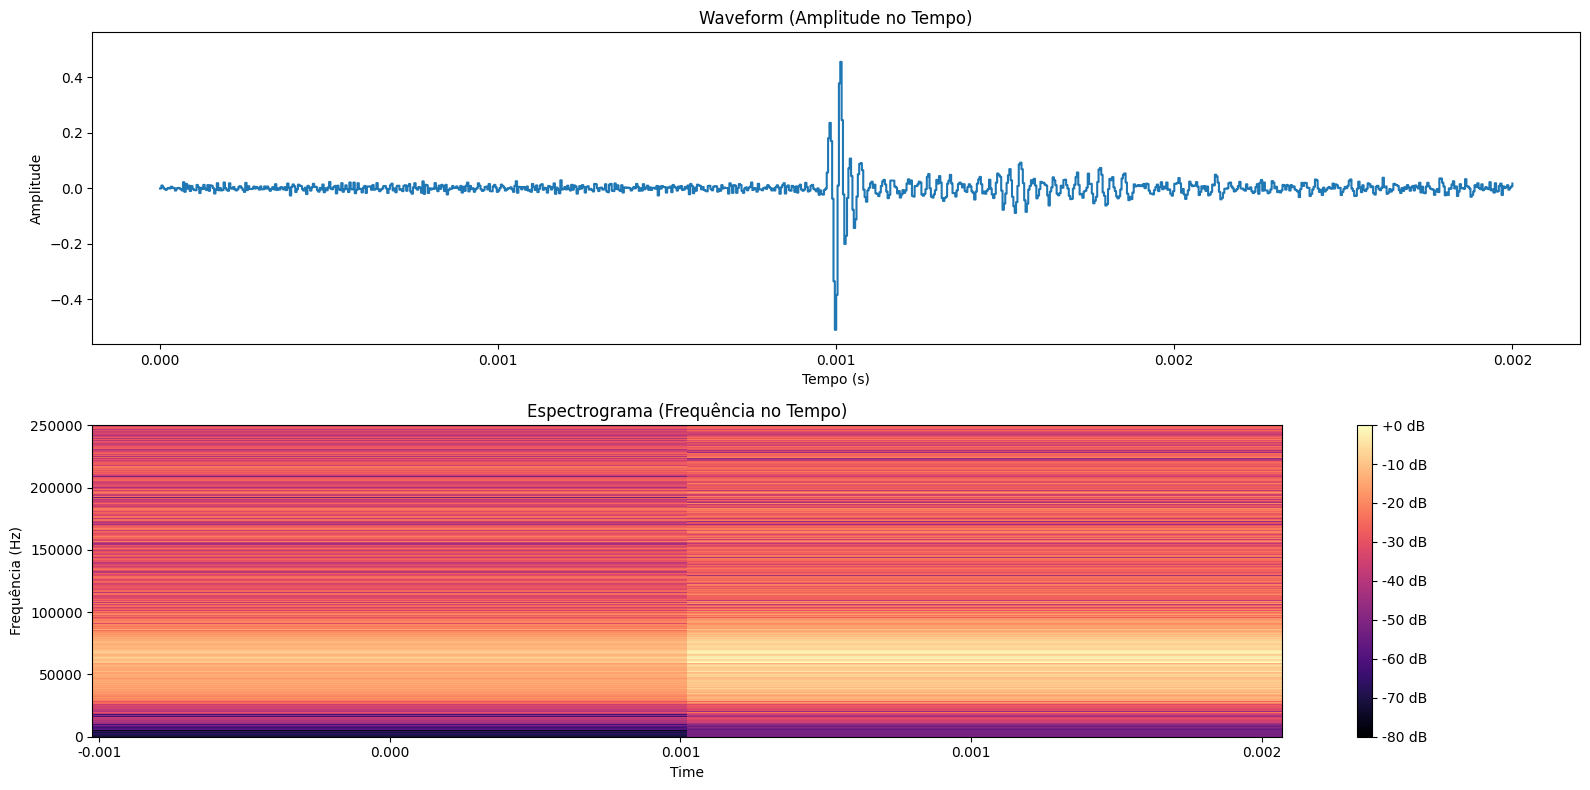

In [6]:
folder_target = 'Tomato Cut'
search_pattern = os.path.join(BASE_PATH, folder_target, '*.wav')
found_files = glob.glob(search_pattern)

file_path = found_files[0]

y, sr = librosa.load(file_path, sr=None)

print(f"Arquivo: {os.path.basename(file_path)}")
print(f"Taxa de Amostragem (SR): {sr} Hz")
print(f"Total de Amostras: {len(y)}")
print(f"Duração: {len(y)/sr} segundos")

plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform (Amplitude no Tempo)')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma (Frequência no Tempo)')
plt.ylabel('Frequência (Hz)')

plt.tight_layout()
plt.show()

# Preparação dos Dados

In [7]:
def validate_audio_file(file_path, min_samples=100):
    """
    Valida se arquivo de áudio pode ser carregado corretamente.
    Retorna: (is_valid, y, sr) ou (False, None, None)
    """
    try:
        y, sr = librosa.load(file_path, sr=None)

        if len(y) == 0:
            return False, None, None

        # mínimo de amostras
        if len(y) < min_samples:
            return False, None, None

        # se não contém NaN ou Inf
        if np.any(np.isnan(y)) or np.any(np.isinf(y)):
            return False, None, None

        return True, y, sr

    except Exception as e:
        return False, None, None


In [8]:
# Coletar e validar todos os arquivos
all_files_valid = []
all_labels_valid = []
corrupted_files = []

label_mapping = {
    'Tomato Dry': 0,
    'Tomato Cut': 1,
    'Tobacco Dry': 2,
    'Tobacco Cut': 3,
    'Empty Pot': 4
}

for folder in folders:
    folder_path = os.path.join(BASE_PATH, folder)
    files = glob.glob(os.path.join(folder_path, '*.wav'))

    valid_count = 0
    corrupt_count = 0

    for file_path in tqdm(files, desc=f"  {folder}"):
        is_valid, _, _ = validate_audio_file(file_path)

        if is_valid:
            all_files_valid.append(file_path)
            all_labels_valid.append(label_mapping[folder])
            valid_count += 1
        else:
            corrupted_files.append(file_path)
            corrupt_count += 1

print(f"  Total de arquivos válidos: {len(all_files_valid)}")
print(f"  Total de arquivos corrompidos: {len(corrupted_files)}")

  Tomato Dry:   0%|          | 0/1622 [00:00<?, ?it/s]

  Empty Pot: 100%|██████████| 1036/1036 [00:05<00:00, 188.30it/s]

  Total de arquivos válidos: 4099
  Total de arquivos corrompidos: 0


In [9]:
# Divição  (70/15/15)

# Split 70/30
X_train_files, X_temp_files, y_train, y_temp = train_test_split(
    all_files_valid,
    all_labels_valid,
    test_size=0.30,
    random_state=42,
    stratify=all_labels_valid
)

# Split 15/15 do temp
X_val_files, X_test_files, y_val, y_test = train_test_split(
    X_temp_files,
    y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print(f"\nDivisão concluída:")
print(f"  Treino     : {len(X_train_files)} arquivos ({len(X_train_files)/len(all_files_valid)*100:.1f}%)")
print(f"  Validação  : {len(X_val_files)} arquivos ({len(X_val_files)/len(all_files_valid)*100:.1f}%)")
print(f"  Teste      : {len(X_test_files)} arquivos ({len(X_test_files)/len(all_files_valid)*100:.1f}%)")

# Verificar estratificação
label_mapping_inverse = {v: k for k, v in label_mapping.items()}

print("\nDistribuição por classe:")
for split_name, y_split in [('Treino', y_train), ('Validação', y_val), ('Teste', y_test)]:
    print(f"\n{split_name}:")
    unique, counts = np.unique(y_split, return_counts=True)
    for label, count in zip(unique, counts):
        print(f"  {label_mapping_inverse[label]:20}: {count:4} ({count/len(y_split)*100:.1f}%)")


Divisão concluída:
  Treino     : 2869 arquivos (70.0%)
  Validação  : 615 arquivos (15.0%)
  Teste      : 615 arquivos (15.0%)

Distribuição por classe:

Treino:
  Tomato Dry          : 1135 (39.6%)
  Tomato Cut          :  462 (16.1%)
  Tobacco Dry         :  193 (6.7%)
  Tobacco Cut         :  354 (12.3%)
  Empty Pot           :  725 (25.3%)

Validação:
  Tomato Dry          :  243 (39.5%)
  Tomato Cut          :   99 (16.1%)
  Tobacco Dry         :   41 (6.7%)
  Tobacco Cut         :   76 (12.4%)
  Empty Pot           :  156 (25.4%)

Teste:
  Tomato Dry          :  244 (39.7%)
  Tomato Cut          :   99 (16.1%)
  Tobacco Dry         :   41 (6.7%)
  Tobacco Cut         :   76 (12.4%)
  Empty Pot           :  155 (25.2%)


In [10]:
# Calculando pesos das classes

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("\nPesos calculados:")
for label, weight in class_weights_dict.items():
    print(f"  {label_mapping_inverse[label]:20}: {weight:.3f}")


Pesos calculados:
  Tomato Dry          : 0.506
  Tomato Cut          : 1.242
  Tobacco Dry         : 2.973
  Tobacco Cut         : 1.621
  Empty Pot           : 0.791


In [11]:
def extract_features_mel_spec(file_path, n_mels=128, max_frames=64):
    y, sr = librosa.load(file_path, sr=None)

    # Parâmetros
    N_FFT = 1024
    HOP_LENGTH = 256
    
    # Obter Mel-Espectrograma
    mel_spec = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=n_mels
    )
    # Converter para escala logarítmica
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Padronização temporal
    if mel_spec_db.shape[1] > max_frames:
        mel_spec_db = mel_spec_db[:, :max_frames]
    elif mel_spec_db.shape[1] < max_frames:
        pad_width = max_frames - mel_spec_db.shape[1]
        # Pad com um valor pequeno para escala dB
        mel_spec_db = np.pad(mel_spec_db, pad_width=((0, 0), (0, pad_width)), mode='constant', constant_values=np.min(mel_spec_db))

    # Retorna a matriz 2D (Frequência x Tempo)
    return mel_spec_db

In [12]:
datasets = {
    'train': (X_train_files, y_train),
    'validation': (X_val_files, y_val),
    'test': (X_test_files, y_test)
}

N_MELS = 128    # Número de bandas de frequência 
MAX_FRAMES = 64 # Número de frames temporais

X_processed = {}
Y_processed = {}

# Processamento e Extração
for set_name, (files, labels) in datasets.items():
    print(f"\nProcessando conjunto: {set_name}...")
    X_list = []

    for file_path in tqdm(files, desc=f"  Extraindo features ({set_name})"):
        try:
            features = extract_features_mel_spec(file_path, n_mels=N_MELS, max_frames=MAX_FRAMES)
            X_list.append(features.flatten()) # Achatamos apenas para o StandardScaler funcionar
        except Exception as e:
            print(f"Arquivo pulado ({set_name}): {os.path.basename(file_path)} - Erro: {e}")

    X_processed[set_name] = np.array(X_list)
    Y_processed[set_name] = np.array(labels)

    print(f"Formato final de X_{set_name} (Achatado p/ Scale): {X_processed[set_name].shape}")


FEATURE_DIM = (N_MELS * MAX_FRAMES)
print(f"\nDimensão de Feature por amostra: {FEATURE_DIM} ({N_MELS} * {MAX_FRAMES})")


Processando conjunto: train...


  Extraindo features (train):   0%|          | 0/2869 [00:00<?, ?it/s]c:\Users\a-a-c\anaconda3\envs\ml\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=1001
  warnings.warn(
c:\Users\a-a-c\anaconda3\envs\ml\Lib\site-packages\librosa\feature\spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
  Extraindo features (train): 100%|██████████| 2869/2869 [00:05<00:00, 515.90it/s]


Formato final de X_train (Achatado p/ Scale): (2869, 8192)

Processando conjunto: validation...


  Extraindo features (validation): 100%|██████████| 615/615 [00:01<00:00, 526.04it/s]


Formato final de X_validation (Achatado p/ Scale): (615, 8192)

Processando conjunto: test...


  Extraindo features (test): 100%|██████████| 615/615 [00:01<00:00, 530.63it/s]

Formato final de X_test (Achatado p/ Scale): (615, 8192)

Dimensão de Feature por amostra: 8192 (128 * 64)


In [13]:
##  StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_processed['train'])
X_val_scaled = scaler.transform(X_processed['validation'])
X_test_scaled = scaler.transform(X_processed['test'])

N_MELS = 128
MAX_FRAMES = 64

# Redimensionamento para CNN 
# (N_amostras, Altura=Frequência, Largura=Tempo, Canais=1)
X_train = X_train_scaled.reshape(-1, N_MELS, MAX_FRAMES, 1)
X_val = X_val_scaled.reshape(-1, N_MELS, MAX_FRAMES, 1)
X_test = X_test_scaled.reshape(-1, N_MELS, MAX_FRAMES, 1)

print("\n--- Formato Final para CNN ---")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

data_to_save = {
    'X_train': X_train, 'y_train': Y_processed['train'],
    'X_val': X_val, 'y_val': Y_processed['validation'],
    'X_test': X_test, 'y_test': Y_processed['test'],
    'scaler': scaler,
    'label_mapping_inverse': label_mapping_inverse
}

# Salvamento dos dados processados
SAVE_PATH = os.path.join(os.getcwd(),'processed')

# Cria o diretório se não existir
os.makedirs(SAVE_PATH, exist_ok=True)

with open(os.path.join(SAVE_PATH, 'bioacustica_features.pkl'), 'wb') as f:
    pickle.dump(data_to_save, f)

print(f"\nDados processados salvos em: {os.path.join(SAVE_PATH, 'bioacustica_features.pkl')}")


--- Formato Final para CNN ---
X_train shape: (2869, 128, 64, 1)
X_val shape: (615, 128, 64, 1)
X_test shape: (615, 128, 64, 1)

Dados processados salvos em: c:\Workspace\DataScienceML_Portfolio\projeto_final\processed\bioacustica_features.pkl


# Modelagem

In [14]:
FILE_PATH = os.path.join(SAVE_PATH, 'bioacustica_features.pkl')

with open(FILE_PATH, 'rb') as f:
  data_loaded = pickle.load(f)

X_train = data_loaded['X_train']
y_train = data_loaded['y_train']
X_val = data_loaded['X_val']
y_val = data_loaded['y_val']
X_test = data_loaded['X_test']
y_test = data_loaded['y_test']

# Mapeamento de rótulos
label_mapping_inverse = data_loaded['label_mapping_inverse']

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (2869, 128, 64, 1)
X_test shape: (615, 128, 64, 1)


In [15]:
print("\n Dimensionalidade dos Features (X) ")
print(f"X_train (Amostras, Features): {X_train.shape}")
print(f"X_val (Amostras, Features): {X_val.shape}")
print(f"X_test (Amostras, Features): {X_test.shape}")
print(f"Número de Features por Amostra: {X_train.shape[1]}")

print("\n Dimensionalidade dos Rótulos (y) ")
print(f"y_train (Amostras): {y_train.shape}")
print(f"y_val (Amostras): {y_val.shape}")
print(f"y_test (Amostras): {y_test.shape}")


print("\n Tipos de Dados (dtype) ")
print(f"X_train dtype: {X_train.dtype}")
print(f"y_train dtype: {y_train.dtype}")


print("\n Primeiras 3 linhas de X_train (Features Padronizados) ")
print(X_train[:3, :5])
print(Counter(y_train))

print("\n Mapeamento de Rótulos (Inteiro -> Categoria) ")
print(label_mapping_inverse)


 Dimensionalidade dos Features (X) 
X_train (Amostras, Features): (2869, 128, 64, 1)
X_val (Amostras, Features): (615, 128, 64, 1)
X_test (Amostras, Features): (615, 128, 64, 1)
Número de Features por Amostra: 128

 Dimensionalidade dos Rótulos (y) 
y_train (Amostras): (2869,)
y_val (Amostras): (615,)
y_test (Amostras): (615,)

 Tipos de Dados (dtype) 
X_train dtype: float32
y_train dtype: int64

 Primeiras 3 linhas de X_train (Features Padronizados) 
[[[[ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]
   [ 0.8144863]

In [16]:
y_train_cnn = to_categorical(y_train, num_classes=5)
y_val_cnn = to_categorical(y_val, num_classes=5)
num_classes = y_train_cnn.shape[1]

N_MELS = X_train.shape[1]
MAX_FRAMES = X_train.shape[2]

model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(N_MELS, MAX_FRAMES, 1)))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4)) 

# Classificador Densa
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.6)) 
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

c:\Users\a-a-c\anaconda3\envs\ml\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 62, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 6, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 6, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 4, 128)     │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 419,461 (1.60 MB)

 Trainable params: 419,461 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Treinamento da CNN
es_callback = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train_cnn,
    validation_data=(X_val, y_val_cnn),
    batch_size=32,
    epochs=100,
    callbacks=[es_callback],
    class_weight=class_weights_dict,
    verbose=1
)

val_loss, val_acc = model.evaluate(X_val, y_val_cnn, verbose=0)
cnn_optimized = model

Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.2788 - loss: 1.5505 - val_accuracy: 0.3659 - val_loss: 1.4105
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.4099 - loss: 1.3866 - val_accuracy: 0.4423 - val_loss: 1.2590
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.4545 - loss: 1.2732 - val_accuracy: 0.4862 - val_loss: 1.1355
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.4699 - loss: 1.2293 - val_accuracy: 0.5512 - val_loss: 1.0738
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5023 - loss: 1.1893 - val_accuracy: 0.5154 - val_loss: 1.1108
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.4810 - loss: 1.1897 - val_accuracy: 0.5724 - val_loss: 1.0402
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5145 - loss: 1.1646 - val_accuracy: 0.5268 - val_loss: 1.0492
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5214 - loss: 1.1555 - val_accuracy: 0.

# Avaliação

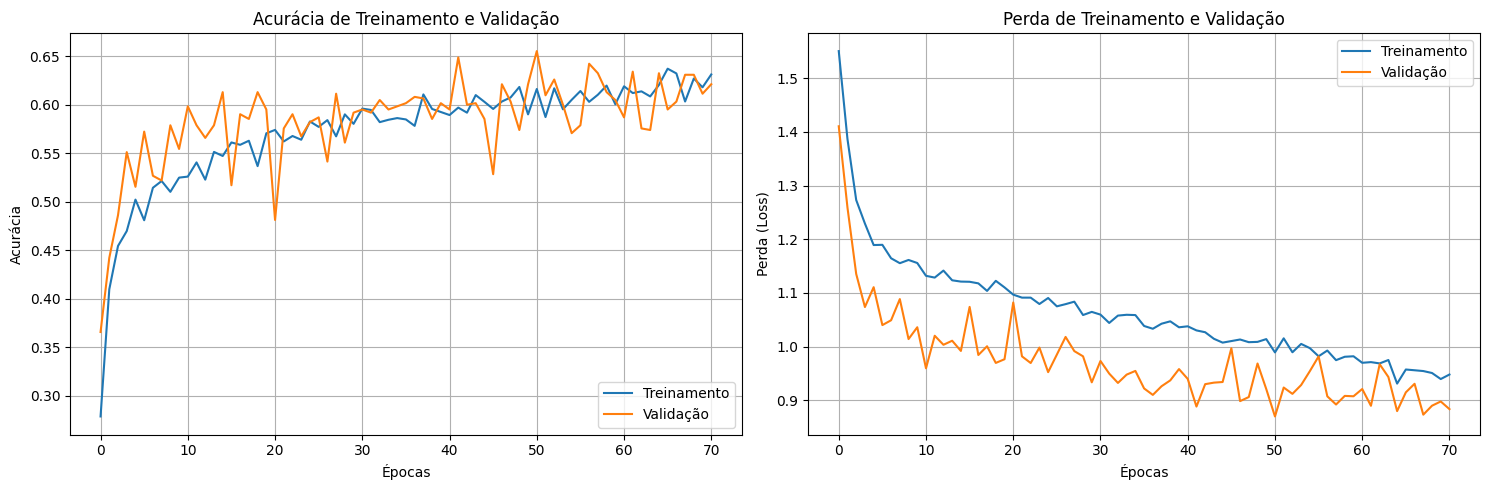

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 5))

# Gráfico de Acurácia
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Treinamento')
plt.plot(epochs_range, val_acc, label='Validação')
plt.title('Acurácia de Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend(loc='lower right')
plt.grid(True)

# Gráfico de Perda (Loss)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Treinamento')
plt.plot(epochs_range, val_loss, label='Validação')
plt.title('Perda de Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda (Loss)')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

--- Relatório de Classificação (Conjunto de Teste) ---
              precision    recall  f1-score   support

  Tomato Dry      0.762     0.709     0.735       244
  Tomato Cut      0.514     0.384     0.439        99
 Tobacco Dry      0.157     0.195     0.174        41
 Tobacco Cut      0.352     0.566     0.434        76
   Empty Pot      0.993     0.903     0.946       155

    accuracy                          0.654       615
   macro avg      0.556     0.551     0.546       615
weighted avg      0.689     0.654     0.666       615



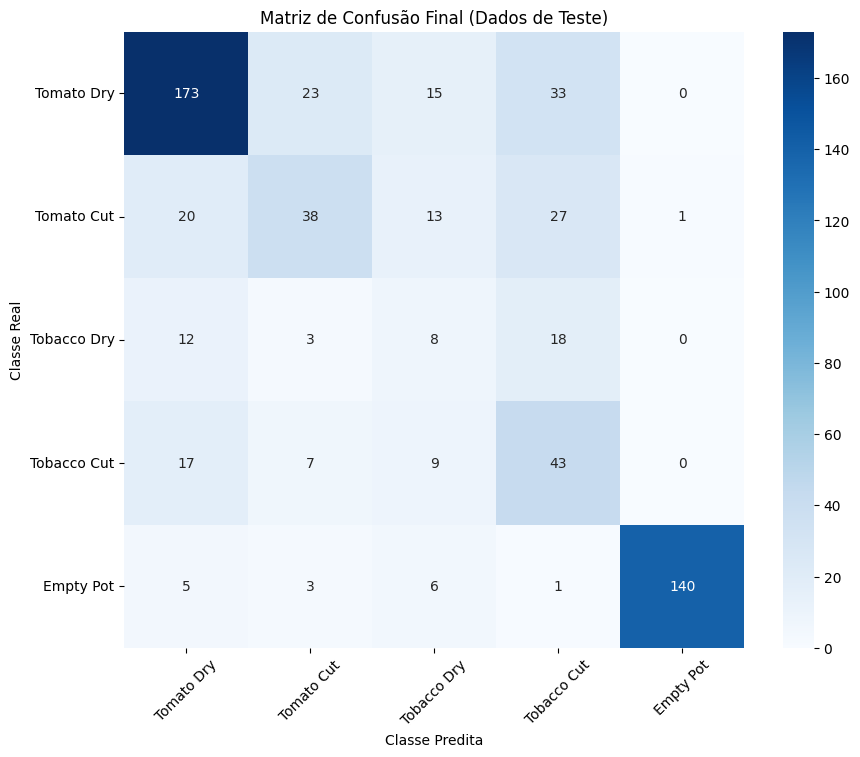

In [19]:
y_pred_proba = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_proba, axis=1)

# Se y_test estiver em formato categorical (One-Hot), converta para índices
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test_true = np.argmax(y_test, axis=1)
else:
    y_test_true = y_test

# 1. Relatório de Classificação (Precision, Recall, F1-Score)
print("\n--- Relatório de Classificação (Conjunto de Teste) ---")
print(classification_report(
    y_test_true, 
    y_pred_classes, 
    target_names=label_mapping_inverse.values(),
    digits=3
))

# 2. Matriz de Confusão
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_true, y_pred_classes)

sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_mapping_inverse.values(),
    yticklabels=label_mapping_inverse.values()
)

plt.title('Matriz de Confusão Final (Dados de Teste)')
plt.ylabel('Classe Real')
plt.xlabel('Classe Predita')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [20]:
# Realizar predições
y_pred_proba = cnn_optimized.predict(X_val)
y_pred_val = np.argmax(y_pred_proba, axis=1)

# Relatório de Classificação
result_classification_report = classification_report(
      y_val,
    y_pred_val,
    target_names=label_mapping_inverse.values(),
    digits=3
)
print(result_classification_report)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
              precision    recall  f1-score   support

  Tomato Dry      0.755     0.712     0.733       243
  Tomato Cut      0.425     0.343     0.380        99
 Tobacco Dry      0.208     0.268     0.234        41
 Tobacco Cut      0.368     0.513     0.429        76
   Empty Pot      0.993     0.936     0.964       156

    accuracy                          0.655       615
   macro avg      0.550     0.555     0.548       615
weighted avg      0.678     0.655     0.664       615



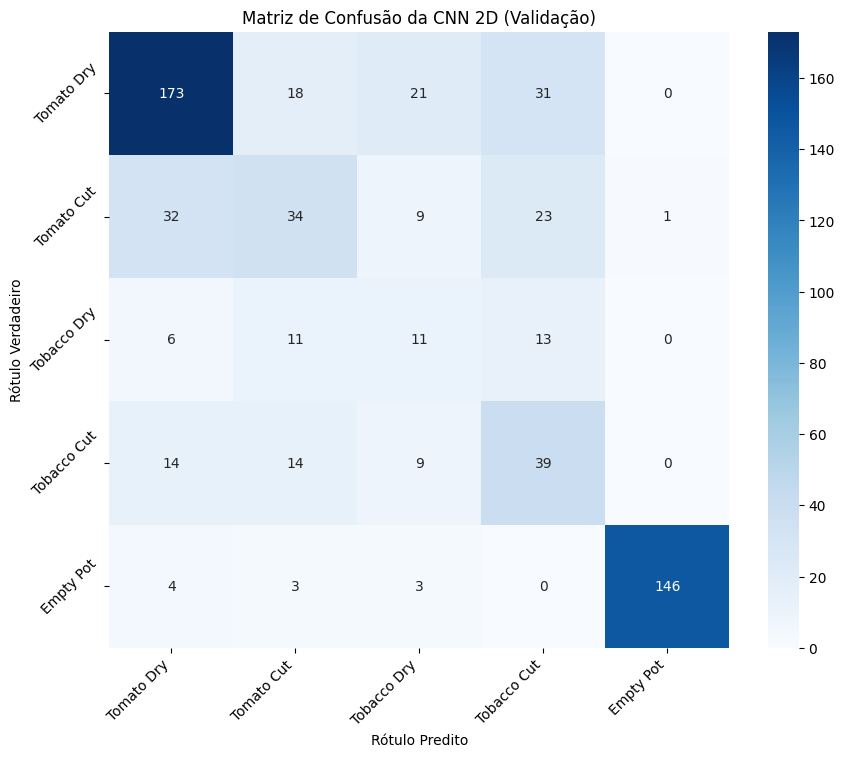

In [21]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_val, y_pred_val)
class_names = [label_mapping_inverse[i] for i in sorted(label_mapping_inverse.keys())]

plt.figure(figsize=(10, 8))

sns.heatmap(
    conf_matrix,
    annot=True, 
    fmt='d',
    cmap='Blues',
    xticklabels=class_names, 
    yticklabels=class_names
)
plt.title('Matriz de Confusão da CNN 2D (Validação)')
plt.xlabel('Rótulo Predito')
plt.ylabel('Rótulo Verdadeiro')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)
plt.show()

In [22]:
# Re-treinamento e Teste Final

# Combinação dos conjuntos de Treino e Validação
X_train_final = np.concatenate((X_train, X_val), axis=0)
y_train_final = np.concatenate((y_train_cnn, y_val_cnn), axis=0)

# Definição do EarlyStopping para o re-treinamento
early_stop = EarlyStopping(
    monitor='loss',
    patience=20,
    verbose=1
)

# Re-treinamento do modelo em todo o dataset (Treino + Validação)
history_final = model.fit(
    X_train_final,
    y_train_final,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.6627 - loss: 0.8205
Epoch 2/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.6682 - loss: 0.8241
Epoch 3/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.6708 - loss: 0.8130
Epoch 4/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6788 - loss: 0.7966
Epoch 5/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.6843 - loss: 0.7989
Epoch 6/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.6889 - loss: 0.7800
Epoch 7/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6912 - loss: 0.7673
Epoch 8/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.6866 - loss: 0.7822
Epoch 9/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.6831 - loss: 0.7843
Epoch 10/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.6866 - loss: 0.7652
Epoch 11/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.6834 - loss: 0.7795
Epoch 12/100
109/109 ━━━━━━━━━

In [23]:
# Avaliação Final no Conjunto de Teste
y_pred_test = model.predict(X_test)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)

# Preparação do conjunto de teste para o relatório
y_test_classes = np.argmax(to_categorical(y_test, num_classes=5), axis=1)

result_classification_report = classification_report(
  y_test_classes, 
  y_pred_classes_test, 
  target_names=class_names, 
  digits=3
)
print(result_classification_report)

cm_test = confusion_matrix(y_test_classes, y_pred_classes_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
              precision    recall  f1-score   support

  Tomato Dry      0.642     0.926     0.758       244
  Tomato Cut      0.620     0.313     0.416        99
 Tobacco Dry      0.182     0.049     0.077        41
 Tobacco Cut      0.468     0.289     0.358        76
   Empty Pot      0.974     0.974     0.974       155

    accuracy                          0.702       615
   macro avg      0.577     0.510     0.517       615
weighted avg      0.670     0.702     0.663       615



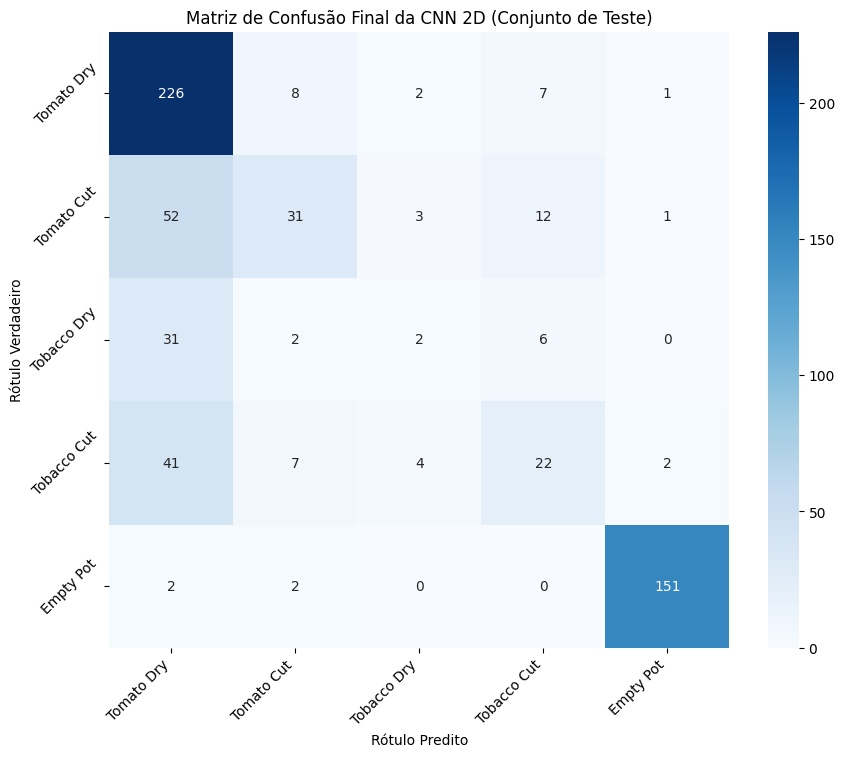

In [24]:
# Matriz de Confusão Final
plt.figure(figsize=(10, 8))

sns.heatmap(
    cm_test,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Matriz de Confusão Final da CNN 2D (Conjunto de Teste)')
plt.xlabel('Rótulo Predito')
plt.ylabel('Rótulo Verdadeiro')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)
plt.show()

In [25]:
model.save('processed/audio_model.keras')
joblib.dump(scaler, 'processed/audio_scaler.pkl')

print("Modelo e Scaler salvos com sucesso para uso na API!")

Modelo e Scaler salvos com sucesso para uso na API!


## Análise Final do Projeto: Plants Sound

Este trabalho baseia-se na pesquisa que estabeleceu a viabilidade de utilizar sons ultrassônicos emitidos por plantas como indicadores de estresse. O estudo de referência de **Khait et al. (2023)** utilizou gravação em ambientes controlados para demonstrar que plantas emitem sons detectáveis quando submetidas a diferentes tipos de estresse, como desidratação ou corte.

A **abordagem primária do artigo original** era a validação científica e a classificação de categorias de estresse, focando, em muitos casos, em **classificações binárias** (por exemplo, diferenciar `Tomato Dry` de `Tomato Cut`).

O **objetivo deste projeto**, no entanto, é: desenvolver um modelo de *machine learning* capaz de realizar uma **classificação multiclasse** robusta e confiável entre **cinco categorias distintas** de estado da planta. Isso inclui não apenas os diferentes tipos de estresse (`Tomato Dry`, `Tomato Cut`, `Tobacco Dry`, `Tobacco Cut`), mas também o estado de controle (`Empty Pot`), exigindo do modelo uma capacidade de discriminação mais elevada do que a encontrada na literatura base.

### **Desafios do Tratamento do Sinal de Áudio**

A qualidade da informação de entrada foi a principal barreira. Os sons ultrassônicos de estresse são transientes (curtos) e inerentemente similares, exigindo uma representação rica para serem discriminados.

- **MFCC (Mel-Frequency Cepstral Coefficients):** Iniciamos com os MFCCs por serem uma representação compacta. O MFCC **resume o conteúdo de frequência** em coeficientes, reduzindo o volume de dados. Essa escolha inicial, embora eficiente, provou-se insuficiente, pois a compressão **eliminou os detalhes sutis** necessários para diferenciar os estresses.
- **Mel-Espectrograma:** A falha do MFCC levou à migração. O Mel-Espectrograma é uma **imagem de tempo-frequência** que retém muito mais detalhes sobre a distribuição de energia do sinal, fornecendo à rede neural um *feature* com alta riqueza de informação. Essa foi a decisão crítica que permitiu o avanço do projeto.

### Escolhas e Evolução do Modelo de Classificação

O modelo precisou evoluir para corresponder à complexidade dos dados.

- **XGBoost (Baseline):** Usado para estabelecer o desempenho inicial. O XGBoost, sendo um modelo tabular, **não conseguia capturar o contexto temporal** do clique. Seu desempenho limitado validou a necessidade de usar modelos que entendem relações espaciais e temporais.
- **CNN 2D (Redes Convolucionais):** A escolha foi o modelo ideal para o problema. A CNN 2D trata o Mel-Espectrograma como uma imagem, usando filtros convolucionais para **aprender automaticamente os padrões de textura** e forma do clique. A arquitetura foi otimizada para ser mais profunda e usar alta regularização (*Dropout*) para lidar com a alta dimensão do Mel-Espectrograma.

### Resultado Final e Limitação da Avaliação

A avaliação final foi realizada no conjunto de Teste, utilizando a melhor arquitetura do projeto (CNN 2D Otimizada com Mel-Espectrograma).

O modelo alcançou uma **Acurácia Geral de 70.6%**, o resultado mais alto do projeto. No entanto, a análise do *Recall* para as classes de estresse revela a limitação imposta pela escassez de dados:

- **Classes Dominantes:** O modelo é altamente eficaz em identificar `Tomato Dry` e `Empty Pot` (classes com mais dados), demonstrando sua capacidade de aprendizado.
- **Classes Críticas:** O *Recall* de `Tobacco Dry` **caiu para apenas 4.9%** no conjunto de Teste. Isso significa que o modelo, na incerteza (causada pela falta de amostras de treino), preferiu classificar amostras de `Tobacco Dry` incorretamente como a classe majoritária (`Tomato Dry`), o que inflacionou a acurácia geral, mas comprometeu a detecção.

**Conclusão Final:** O projeto demonstrou que a metodologia (Mel-Espectrograma + CNN 2D) é a correta para este problema. Contudo, o teto de desempenho para as classes minoritárias é imposto pela **insuficiência de dados** para as classes de estresse, um obstáculo que a otimização do modelo não conseguiu superar. A próxima etapa de pesquisa e desenvolvimento exige a **expansão do *dataset* de amostras de estresse.**'